# Gesture Recognition (Vedhavathi Nanjappa, Vinay Rana, Vinay)
Build a 3D Conv model that will be able to predict the 5 gestures correctly. Import the following libraries to get started.

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

In [ ]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize as imresize
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Set the random seed to 30.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/Project_data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

Read the folder names for training and validation. Batch size is set to 32. Set the batch size so that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 32

In [ ]:
enable_augmentation = False # augmentation of Data
seq_idx = range(0,30,3)
dim_x, dim_y = 160, 160

Below is the overall structure of the generator. In the generator, we will  preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [ ]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    img_idx = seq_idx
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        print(len(t))


        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1

        print(num_batches)

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))


                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = imresize(image, (y,z,3))


                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


663
663


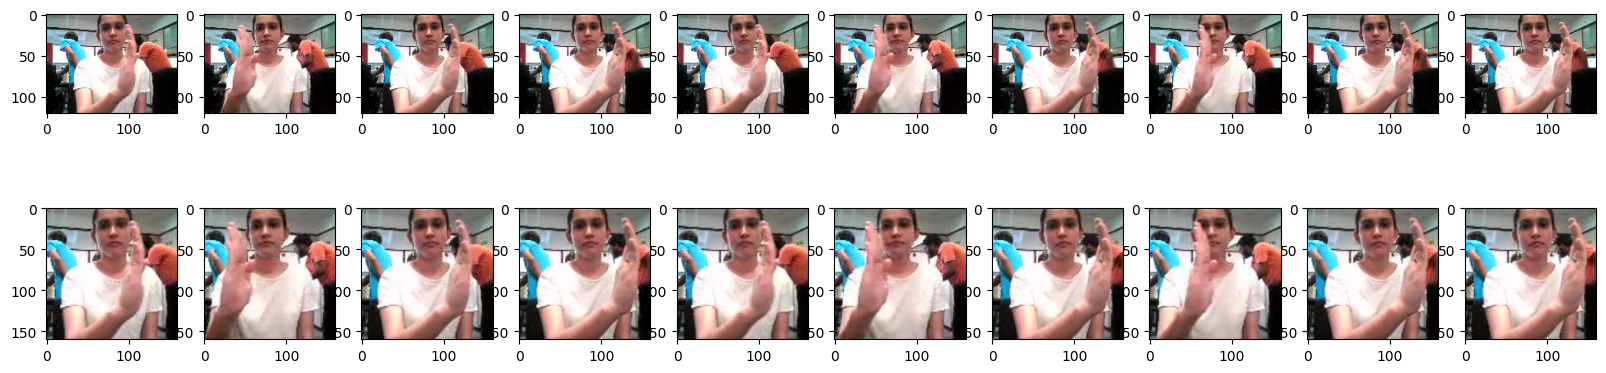

In [ ]:
# testing generator
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

# Model 1


In [ ]:
model1 = Sequential()
model1.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model1.add(MaxPooling3D(pool_size=2))

model1.add(Conv3D(64, kernel_size=3, activation='relu'))
model1.add(MaxPooling3D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.02) #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 158, 158, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 79, 79, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 77, 77, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 38, 38, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 92416)             0         
                                                                 
 dense (Dense)               (None, 256)               2

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

663
21
Epoch 1/50
20/21 [===========================>..] - ETA: 3s - loss: 527.8763 - categorical_accuracy: 0.2141663
21
21/21 [==============================] - ETA: 0s - loss: 502.7950 - categorical_accuracy: 0.2232100
4
100
4

Epoch 1: saving model to model_init_exp_16_2024-01-0109_48_54.466865/model-00001-502.79498-0.22321-1.26544-0.35938.h5
21/21 [==============================] - 107s 5s/step - loss: 502.7950 - categorical_accuracy: 0.2232 - val_loss: 1.2654 - val_categorical_accuracy: 0.3594 - lr: 0.0200
Epoch 2/50
20/21 [===========================>..] - ETA: 3s - loss: 1.6135 - categorical_accuracy: 0.2031663
21
21/21 [==============================] - ETA: 0s - loss: 1.5920 - categorical_accuracy: 0.2158100
4

Epoch 2: saving model to model_init_exp_16_2024-01-0109_48_54.466865/model-00002-1.59200-0.21577-1.26217-0.35938.h5
21/21 [==============================] - 95s 5s/step - loss: 1.5920 - categorical_accuracy: 0.2158 - val_loss: 1.2622 - val_categorical_accuracy: 0.3594 -

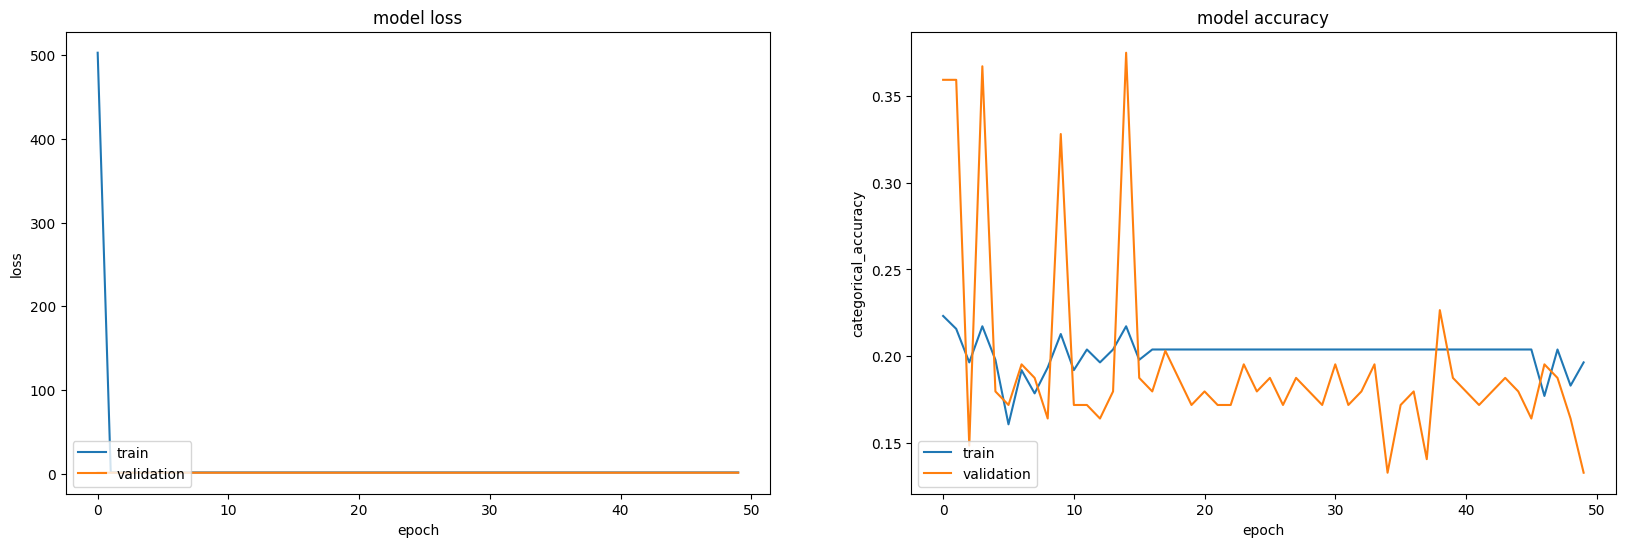

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history1.history['loss'])
ax1 = plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history1.history['categorical_accuracy'])
ax2 = plt.plot(history1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 2


In [ ]:
model2 = Sequential()

model2.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model2.add(Conv3D(64, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization())

model2.add(Conv3D(128, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(BatchNormalization())

model2.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(BatchNormalization())

model2.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model2.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.02) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 8, 158, 158, 32)   2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 156, 156, 64)   55360     
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 3, 78, 78, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization (Batch  (None, 3, 78, 78, 64)     256       
 Normalization)                                                  
                                                                 
 conv3d_4 (Conv3D)           (None, 1, 76, 76, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 1, 38, 38, 128)   

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

663
21
Epoch 1/50
20/21 [===========================>..] - ETA: 3s - loss: 3.0846 - categorical_accuracy: 0.3313663
21
21/21 [==============================] - ETA: 0s - loss: 2.9997 - categorical_accuracy: 0.3244100
4
100
4

Epoch 1: saving model to model_2_2024-01-0109_48_54.466865/model-00001-2.99966-0.32440-12100.95605-0.35938.h5
21/21 [==============================] - 127s 5s/step - loss: 2.9997 - categorical_accuracy: 0.3244 - val_loss: 12100.9561 - val_categorical_accuracy: 0.3594 - lr: 0.0200
Epoch 2/50
20/21 [===========================>..] - ETA: 4s - loss: 1.5435 - categorical_accuracy: 0.4859663
21
21/21 [==============================] - ETA: 0s - loss: 1.5198 - categorical_accuracy: 0.4762100
4

Epoch 2: saving model to model_2_2024-01-0109_48_54.466865/model-00002-1.51984-0.47619-508.45978-0.15625.h5
21/21 [==============================] - 106s 5s/step - loss: 1.5198 - categorical_accuracy: 0.4762 - val_loss: 508.4598 - val_categorical_accuracy: 0.1562 - lr: 0.0200
Epo

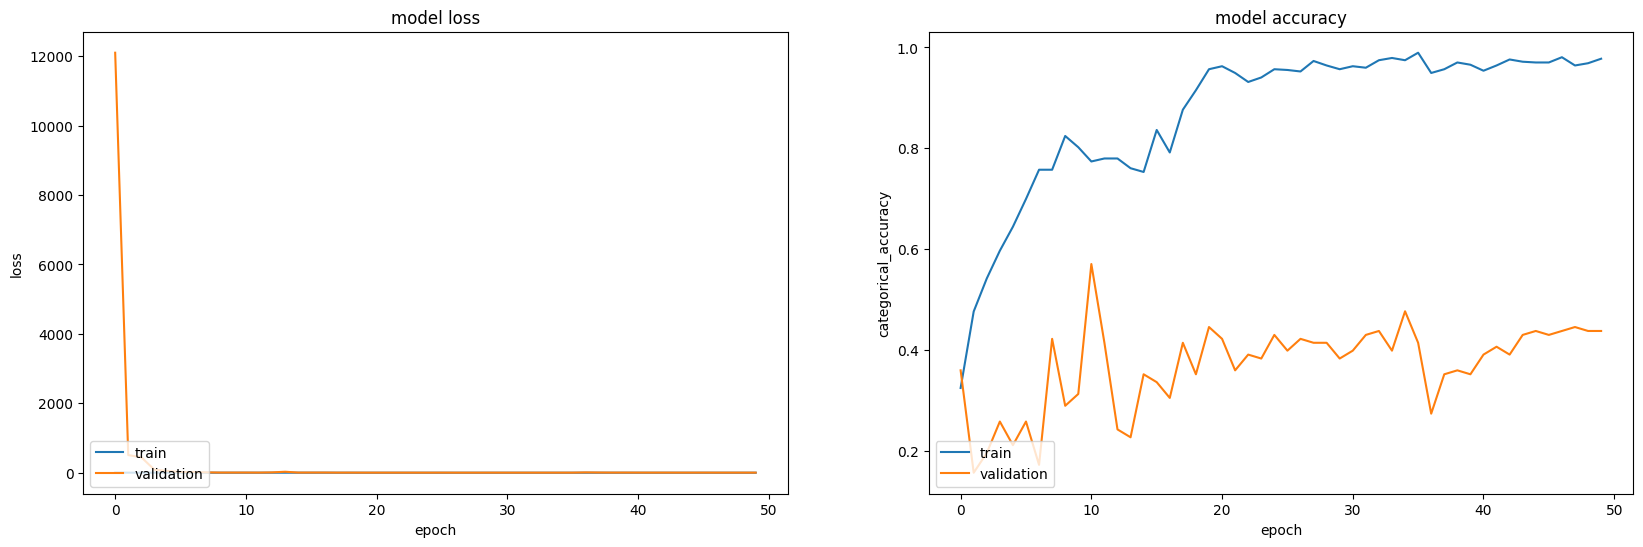

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history2.history['loss'])
ax1 = plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history2.history['categorical_accuracy'])
ax2 = plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 3

In [ ]:
model3 = Sequential()
model3.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model3.add(BatchNormalization())
model3.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model3.add(BatchNormalization())
model3.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model3.add(BatchNormalization())
model3.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model3.add(BatchNormalization())
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 158, 158, 8)   224       
 ributed)                                                        
                                                                 
 batch_normalization (Batch  (None, 10, 158, 158, 8)   32        
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 156, 156, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_1 (Bat  (None, 10, 156, 156, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 154, 154, 8)       6

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + '/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

663
21
Epoch 1/50
20/21 [===========================>..] - ETA: 3s - loss: 1.3382 - categorical_accuracy: 0.4016663
21
21/21 [==============================] - ETA: 0s - loss: 1.3206 - categorical_accuracy: 0.3973100
4
100
4

Epoch 1: saving model to model_3_2024-01-0114_17_17.730669/model-00001-1.32057-0.39732-1.85043-0.14062.h5
21/21 [==============================] - 123s 5s/step - loss: 1.3206 - categorical_accuracy: 0.3973 - val_loss: 1.8504 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 2/50
20/21 [===========================>..] - ETA: 3s - loss: 1.1392 - categorical_accuracy: 0.4969663
21
21/21 [==============================] - ETA: 0s - loss: 1.1348 - categorical_accuracy: 0.4985100
4

Epoch 2: saving model to model_3_2024-01-0114_17_17.730669/model-00002-1.13484-0.49851-1.60262-0.41406.h5
21/21 [==============================] - 99s 5s/step - loss: 1.1348 - categorical_accuracy: 0.4985 - val_loss: 1.6026 - val_categorical_accuracy: 0.4141 - lr: 0.0100
Epoch 3/50
20/21

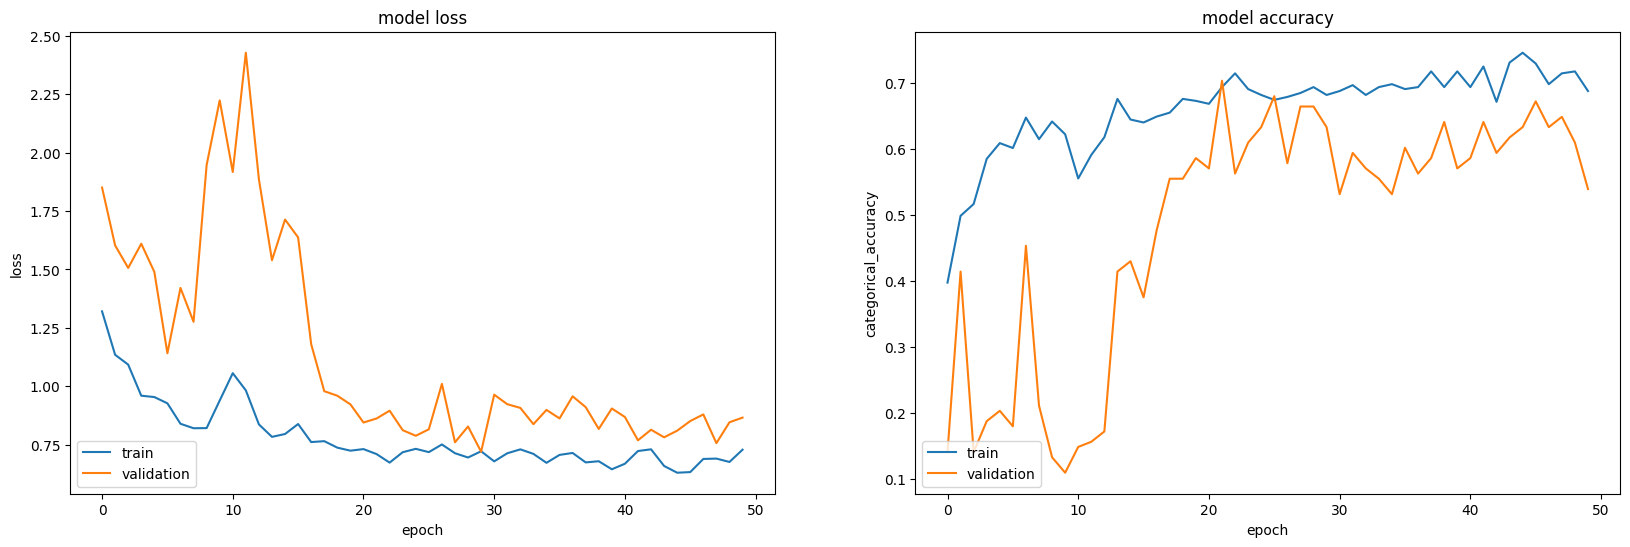

In [ ]:

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [ ]:
from google.colab import files

In [ ]:
model3.save("/content/gdrive/MyDrive")

In [ ]:
model3.save('model3.hdf5')

In [ ]:
model3.save("/content/gdrive/MyDrive/Model3.keras")

In [ ]:
model3.save("/content/gdrive/MyDrive/Model3.h5")